In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import networkx as nx
import itertools
from scipy import signal
from scipy import stats
import gmaps
import gmaps.datasets
import time
from selenium import webdriver
import os
import folium
from folium.plugins import HeatMap
from webdriver_manager.chrome import ChromeDriverManager
driver = webdriver.Chrome(ChromeDriverManager().install())

# 0 Read Data

In [2]:
data = pd.read_pickle("../data/2018_11_formatted.pkl")

In [3]:
data.head()

id                location country state    zip  \
0  1057784377101426689     Guayaquil - Ecuador      ec   NaN  g0100   
1  1057784381379555329           Riverside, CA      us    ca  92501   
2  1057784505258381312  Port Harcourt, Nigeria      ng   NaN    NaN   
3  1057785120625692673     Everywhere you are.      it   NaN  10014   
4  1057785912774586370                 Nigeria      ng   NaN    NaN   

            x          y             published_at  \
0  -79.897461  -2.203820  2018-11-01 00:00:22 UTC   
1 -117.373879  33.981630  2018-11-01 00:00:23 UTC   
2    7.036373   4.772310  2018-11-01 00:00:53 UTC   
3    7.892500  45.284545  2018-11-01 00:03:20 UTC   
4    8.674250   9.084570  2018-11-01 00:06:28 UTC   

                                   author coords_from   retweet_uid  \
0      cecimiosotis (AB. CECILIA HERRERA)    location           NaN   
1  terryquery (#MAGA Gal from Cal ⭐️⭐️⭐️)    location           NaN   
2             wgana_gana (Gana Wakanbaga)    location  1.057184e+18   
3      CizzleOfficial_ (📸C4-photography.)    location  1.057184e+18   
4                      papi_tiz2le (papi)    location  1.057184e+18   

  retweet_uname   response_id response_author lang  \
0           NaN  1.057752e+18         pauli8g   es   
1           NaN  1.057413e+18  joelanthonyatl   en   
2      EmemOhio           NaN             NaN   en   
3      EmemOhio           NaN             NaN   en   
4      EmemOhio           NaN             NaN   en   

                                                text  \
0  @Pauli8g VERDAD, ESOS SON DEL CARTEL DEL TERRO...   
1  @JoelAnthonyATL Born and bred in MS-13 barrios...   
2  RT @EmemOhio: How to verify Tinubu's Drug Cart...   
3  RT @EmemOhio: How to verify Tinubu's Drug Cart...   
4  RT @EmemOhio: How to verify Tinubu's Drug Cart...   

                                            entities  
0  [{'id': 569, 'type': ['Person'], 'matchingToke...  
1  [{'id': 2547, 'type': ['Agent', 'Organisation'...  
2  [{'id': 118, 'type': ['Company'], 'matchingTok...  
3  [{'id': 118, 'type': ['Company'], 'matchingTok...  
4  [{'id': 118, 'type': ['Company'], 'matchingTok...

In [4]:
relevant_data = pd.read_pickle("../data/relevant_tweets/2018_11_relevant.pkl")

In [5]:
def merge_columns(relevant_data, data):
    '''
    There are some columns that relevant data does not have, merge from data using Tweet_id
    columns are: 'published_at', 'location', 'country'
    '''
    col = ['id','published_at', 'location', 'country', 'text']
    merged = pd.merge(relevant_data, data[col], how='left', left_on=['tweet_id'], right_on=['id'])
    merged.drop('id', inplace=True, axis=1)
    return merged

relevant_data = merge_columns(relevant_data, data)

In [6]:
relevant_data.head()

coordinates             tweet_id lang  \
0             7.0363729999999975,4.77231  1057784505258381312   en   
1                       7.8925,45.284545  1057785120625692673   en   
2                        8.67425,9.08457  1057785912774586370   en   
3                        3.42348,6.43918  1057791227100315648   en   
4  3.8952699999999996,7.3788399999999985  1057825536330948608   en   

                entity lop cluster_label             published_at  \
0  tinubus drug cartel   o            43  2018-11-01 00:00:53 UTC   
1  tinubus drug cartel   o            43  2018-11-01 00:03:20 UTC   
2  tinubus drug cartel   o            43  2018-11-01 00:06:28 UTC   
3  tinubus drug cartel   o            43  2018-11-01 00:27:36 UTC   
4  tinubus drug cartel   o            43  2018-11-01 02:43:55 UTC   

                 location country  \
0  Port Harcourt, Nigeria      ng   
1     Everywhere you are.      it   
2                 Nigeria      ng   
3          Lagos, Nigeria      ng   
4         Ibadan, Nigeria      ng   

                                                text  
0  RT @EmemOhio: How to verify Tinubu's Drug Cart...  
1  RT @EmemOhio: How to verify Tinubu's Drug Cart...  
2  RT @EmemOhio: How to verify Tinubu's Drug Cart...  
3  RT @EmemOhio: How to verify Tinubu's Drug Cart...  
4  RT @EmemOhio: How to verify Tinubu's Drug Cart...

In [7]:
figure_path = "../paper/figures/"
relevant_data = relevant_data[relevant_data['entity'] != 'cartel'].copy() # remove entity 'cartel', too generic

# 1. Cluster Analysis

## 1.1 Time series of cluster frequencies (all)

In [10]:
# overall frequency of topics
def plot_entity_frequency(relevant_data):
    relevant_data['day'] = relevant_data['published_at'].apply(lambda row: row.split('-')[2].split(' ')[0])
    plt.style.use('seaborn-darkgrid')
    ax = relevant_data['cluster_label'].value_counts().plot(kind='bar')
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel("Cluster ID", fontsize=15)
    plt.ylabel("Frequency", fontsize=15)
    fig = ax.get_figure()
    fig.savefig(figure_path + "entity_frequencies.png", dpi=100)

In [11]:
plot_entity_frequency(relevant_data)

In [12]:
def get_topic_freq(relevant_data):
    topics_by_day = relevant_data.groupby('day')['cluster_label'].apply(list)
    topic_ids = relevant_data['cluster_label'].unique()
    index = ['2', '14', '18', '25', '26', '43', '52', '55', '70', '73', '77', '78', '98', '99', 'e1']
    topic_freq = pd.DataFrame(columns=topics_by_day.index, index=index)
    days = list(topics_by_day.index)
    for day in days:
        series = pd.Series(topics_by_day.iloc[days.index(day)]).value_counts()
        for cluster_id in series.index:
            topic_freq.loc[cluster_id, day] = series[cluster_id]
    topic_freq = topic_freq.T
    topic_freq.fillna(0, inplace=True)
    topic_freq.reset_index(inplace=True)
    topic_freq.drop('day', axis=1, inplace=True)
    topic_freq.index = range(1, 31)
    return topic_freq

In [59]:
def plot_topic_freq(topic_freq, with_peaks=False, peak_prominence=None, save=False, ylim=6500):
    '''
    inspired by https://python-graph-gallery.com/125-small-multiples-for-line-chart/
    '''
    # Initialize the figure
    plt.style.use('seaborn-darkgrid')

    # create a color palette
    palette = plt.get_cmap('Dark2')
    
    f, axs = plt.subplots(4,4,figsize=(18,10))
    f.delaxes(axs[3][2])
    f.delaxes(axs[3][3])
    
    # multiple line plot
    num=0
    for column in topic_freq:
        num+=1

        # Find the right spot on the plot
        plt.subplot(4,4, num)

        # Plot every groups, but discreet
        for v in topic_freq:
            plt.plot(topic_freq.index, topic_freq[v], marker='', color='grey', linewidth=0.6, alpha=0.5)

        # Plot the lineplot
        plt.plot(topic_freq.index, topic_freq[column], marker='o', markersize=4, color='black', 
                 linewidth=2, alpha=1, label=column)
        
        # Plot peaks 
        if with_peaks:
            peaks = topic_freq[peak_prominence.astype('bool')]
            plt.scatter(peaks.index, peaks[column], marker='o', s=70, linewidth=1, color='red')
        
        plt.xlim(-1,31)
        plt.ylim(0,ylim)

        # xticks only show odd numbers (otherwise too crowded)
        odd_nums = [x for x in range(30) if x%2==0]
        plt.xticks(odd_nums,size='large')
        plt.yticks(size='large')
        
        # Add title
        plt.title("Cluster "+str(column), loc='left', fontsize=20, fontweight=0, color='black')
    
    f.tight_layout() 
    if save:
        if not with_peaks:
            f.savefig(figure_path + "ts_all")
        if with_peaks:
            f.savefig(figure_path + "ts_all_withpeaks")

In [14]:
topic_freq = get_topic_freq(relevant_data)

In [15]:
topic_freq

2    14    18    25    26   43    52    55   70    73    77   78    98  \
1    494   383   994   151   946  332   127   226   69   432   170   36    37   
2    616   413   849   127   721  192   298   272  205   513   147   44   167   
3    484   216   436    97   399   69   130   245   73   316   112   20    64   
4    395   152   616   110   297  111    60   300   47   295   148   64    54   
5    526   122   918   249   967  512    99   497   52   281   343  325   397   
6    815   415  3976   615   541  125   118   515   56   277   612   76    62   
7   1767   772  1098   733   299  139    72   241  103   218   758   27    77   
8   1670   175  1412   148   332  103    56   237   82   261   193   20    52   
9    534   102   275   204   367   83    79   320   72   229   174   17    37   
10   244   201   391   180   232   71    37   185   47   168   121   20    25   
11   216   135   422   192   716   68    57   295  315   252   206   61    22   
12   185   116   301   266  1557   87   117   282   95   276   269   95    23   
13  1751   113   606   340   721  236  1921   332  269   411  1301  240  1319   
14  2533   165  2328  1471   347  159  2844   817  726  1181  2305  283  2418   
15   528   149   810  1393   258  238   663   420  322   694  1563  132   555   
16   762    97  2026   633   300  147   199   354  238   598  1032  197   181   
17   899   195   757   333   346  340    61   328  165   353   466   64   122   
18   645   156   624   290   411  200   111   229  289   973   646   41   378   
19  1587  1365  2048   673   446  255   117   341  223   525   877   77   479   
20  1540   408   695  1280   585  331   215  1184  160   317  1105   68   780   
21  1264   684   407  1253  1086  316   278   995  200   689  1252  115   585   
22   979   271   315   389   347  122   205   279   88   776   644  933   137   
23   792   111   482   368   296  273   123   170   67   803   427  418    31   
24   913   123   561   613   825  192   155   331   96   403   258  294    59   
25   703   344   612  1046   951  139   134   320   92   727   964   59    39   
26   901   390  1190   408  2750  243   129   456   82   460   301   67    71   
27   768   337  1977   344  3444  195   509   386  290  2667   320   76   112   
28   563  1275   909   310  1631  264   159   365  136   730   406   75   117   
29   902  4532  2787   306   779  292   102   496  125   713   346  153    95   
30   478  1459  2193  1269   754  712    78   532  566   598  1060   55   128   

      99    e1  
1    438  2166  
2    278  2079  
3    184  1061  
4    101   688  
5     67  1143  
6    154  4574  
7    260   668  
8    919  1073  
9     97   461  
10    29   848  
11    39   818  
12    38  1031  
13   338   309  
14   584   378  
15   123   480  
16    57   566  
17    55   409  
18    13  1697  
19    57  1986  
20   194   915  
21   812   695  
22   193   635  
23  2645   549  
24  2782   328  
25   335   718  
26   420  3214  
27   253  1298  
28   306  1928  
29  2616  6270  
30  2081  3712

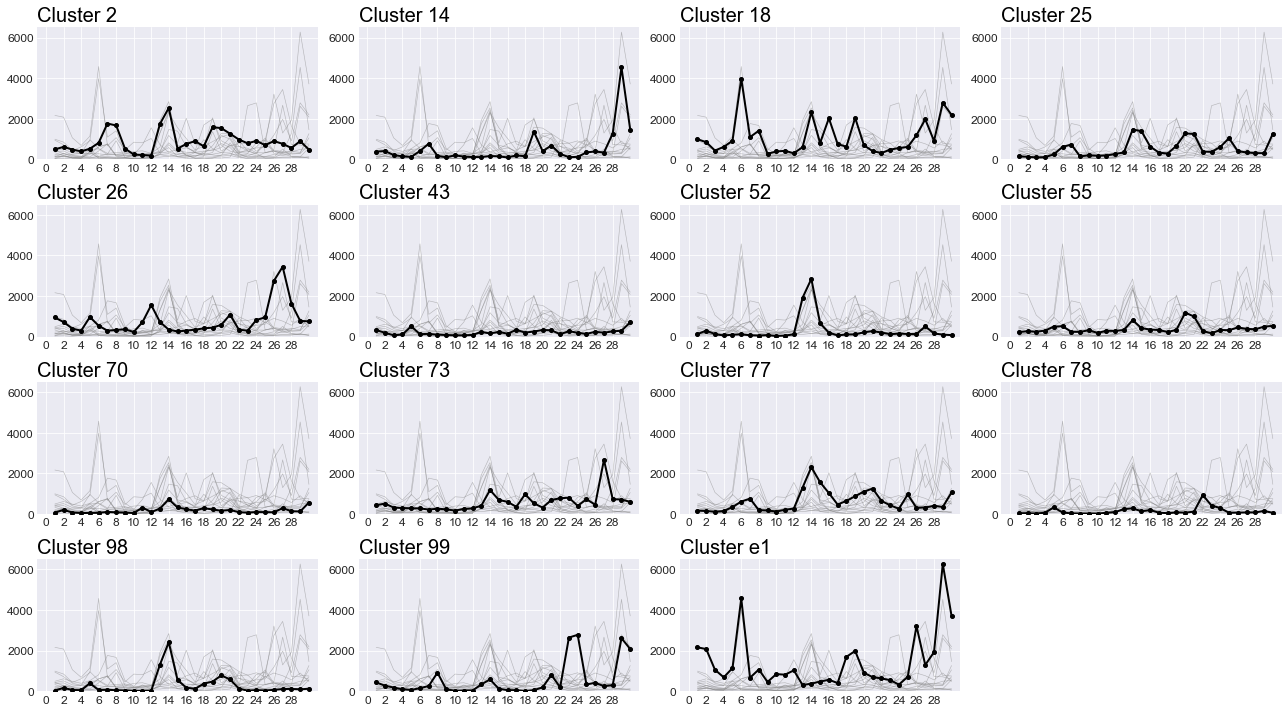

In [60]:
plot_topic_freq(topic_freq, save=True)

- Results so far:
    - On day 14, Cluster 2, 18, 25, 52, 70, 73, 77, and 98 peaked. The day of El Chapo trial.
        - But, do different cluster represents different part of the story? (e.g. immigration related etc.)
    - On day 27, Cluster 26 (American politicians) and 73 (south of the border countries) peaked
    - Cluster 43 (cartel and human trafficking) is reletively smooth. 
    - Cluster 99 (the peak lasted for a few days).

## 1.2 Interprete the Time Series
- Get peaks of each TS (date and intensity)
    - https://stackoverflow.com/questions/1713335/peak-finding-algorithm-for-python-scipy/37009011
- Get high frequency tweets of that day to interprete the peaks
- Get correlations between TS  https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9
- TS sensitivity: Understand why some clusters are "flat" (i.e. peaks are less obvious...relatively...)

### 1.2.1 Find Peaks
- compare days with cluster frequency (i.e. detecting that certain days are imporant days)

In [17]:
def find_peaks(topic_freq, prominence=0):
    '''
    topic_freq:
        a dataframe that has columns of each entity and rows of dates (Nov 2018)
    Return
    ------
        a dataframe that has same col and rows as topic_freq, only peaks are shown (value = peak prominences)
    '''
    
    # pad zeros to beginning and end of each time series (row~a month for an entity)
    matrix = np.matrix(topic_freq.T)
    matrix = np.pad(matrix, pad_width=((0,0),(1,1)), mode='constant')
    
    peak_matrix = np.zeros(matrix.shape)
    
    for i in range(len(matrix)):
        frequency = matrix[i]
        peaks = signal.find_peaks(frequency, prominence=prominence)
        peak_matrix[i][peaks[0],] = peaks[1]['prominences']
    
    peak_df = pd.DataFrame(peak_matrix.T)
    peak_df.columns = topic_freq.columns
    return peak_df

In [18]:
def get_peak_tweets(peaks, relevant_data):
    '''
    For each day, find peak clusters, then find the high frequency tweets of that cluster on that day
    '''
    for day in range(len(peaks)):
        day_peaks = peaks.loc[day]
        cluster_ids = day_peaks.iloc[day_peaks.to_numpy().nonzero()].index
        day_tweets = relevant_data[relevant_data['day'].astype(int)==day]
        
        print("For day ", day)
        print("......", cluster_ids)
        for id_ in cluster_ids:
            representative_tweets = day_tweets[day_tweets['cluster_label']==id_]['text'].value_counts()[:1]
            print("......", id_, representative_tweets)
        print("\n")

In [19]:
peak_prominence = find_peaks(topic_freq)

In [20]:
peak_prominence

2      14      18      25      26     43      52      55     70  \
0      0.0     0.0     0.0     0.0     0.0    0.0     0.0     0.0    0.0   
1      0.0     0.0   558.0    54.0   649.0  263.0     0.0     0.0    0.0   
2    221.0   291.0     0.0     0.0     0.0    0.0   261.0    27.0  158.0   
3      0.0     0.0     0.0     0.0     0.0    0.0     0.0     0.0    0.0   
4      0.0     0.0     0.0     0.0     0.0    0.0     0.0     0.0    0.0   
5      0.0     0.0     0.0     0.0   735.0  444.0     0.0     0.0    0.0   
6      0.0     0.0  3976.0     0.0     0.0    0.0    58.0   330.0    0.0   
7   1582.0   675.0     0.0   585.0     0.0   14.0     0.0     0.0   56.0   
8      0.0     0.0   314.0     0.0     0.0    0.0     0.0     0.0    0.0   
9      0.0     0.0     0.0    24.0    68.0    0.0    23.0    83.0    0.0   
10     0.0    99.0     0.0     0.0     0.0    0.0     0.0     0.0    0.0   
11     0.0     0.0   121.0     0.0     0.0    0.0     0.0    13.0  220.0   
12     0.0     0.0     0.0     0.0  1299.0    0.0     0.0     0.0    0.0   
13     0.0     0.0     0.0     0.0     0.0   77.0     0.0     0.0    0.0   
14  2533.0    52.0  2013.0  1471.0     0.0    0.0  2844.0   588.0  726.0   
15     0.0     0.0     0.0     0.0     0.0   91.0     0.0     0.0    0.0   
16     0.0     0.0  1216.0     0.0     0.0    0.0     0.0     0.0    0.0   
17   254.0    39.0     0.0     0.0     0.0  218.0     0.0     0.0    0.0   
18     0.0     0.0     0.0     0.0     0.0    0.0     0.0     0.0  124.0   
19  1059.0  1254.0  1424.0     0.0     0.0    0.0     0.0     0.0    0.0   
20     0.0     0.0     0.0   990.0     0.0  131.0     0.0  1184.0    0.0   
21     0.0   276.0     0.0     0.0   790.0    0.0   155.0     0.0   40.0   
22     0.0     0.0     0.0     0.0     0.0    0.0     0.0     0.0    0.0   
23     0.0     0.0     0.0     0.0     0.0  134.0     0.0     0.0    0.0   
24   121.0     0.0     0.0     0.0     0.0    0.0    26.0    11.0   14.0   
25     0.0     0.0     0.0   678.0     0.0    0.0     0.0     0.0    0.0   
26   198.0    53.0     0.0     0.0     0.0   48.0     0.0    91.0    0.0   
27     0.0     0.0  1068.0     0.0  3444.0    0.0   448.0     0.0  165.0   
28     0.0     0.0     0.0     0.0     0.0    0.0     0.0     0.0    0.0   
29   339.0  4532.0  2512.0     0.0     0.0    0.0     0.0     0.0    0.0   
30     0.0     0.0     0.0   963.0     0.0  712.0     0.0   362.0  499.0   
31     0.0     0.0     0.0     0.0     0.0    0.0     0.0     0.0    0.0   

        73      77     78      98      99      e1  
0      0.0     0.0    0.0     0.0     0.0     0.0  
1      0.0    58.0    0.0     0.0   371.0  1478.0  
2    345.0     0.0   24.0   113.0     0.0     0.0  
3      0.0     0.0    0.0     0.0     0.0     0.0  
4      0.0     0.0    0.0     0.0     0.0     0.0  
5      0.0     0.0  308.0   375.0     0.0     0.0  
6      0.0     0.0    0.0     0.0     0.0  4265.0  
7      0.0   637.0    0.0    15.0     0.0     0.0  
8     43.0     0.0    0.0     0.0   906.0   405.0  
9      0.0     0.0    0.0     0.0     0.0     0.0  
10     0.0     0.0    0.0     0.0     0.0    30.0  
11     0.0     0.0    0.0     0.0     1.0     0.0  
12     0.0     0.0    0.0     0.0     0.0   570.0  
13     0.0     0.0    0.0     0.0     0.0     0.0  
14   864.0  2305.0  242.0  2418.0   555.0     0.0  
15     0.0     0.0    0.0     0.0     0.0     0.0  
16     0.0     0.0   65.0     0.0     0.0   157.0  
17     0.0     0.0    0.0     0.0     0.0     0.0  
18   620.0     0.0    0.0     0.0     0.0     0.0  
19     0.0     0.0    9.0     0.0     0.0  1658.0  
20     0.0     0.0    0.0   658.0     0.0     0.0  
21     0.0   786.0    0.0     0.0   619.0     0.0  
22     0.0     0.0  933.0     0.0     0.0     0.0  
23   400.0     0.0    0.0     0.0     0.0     0.0  
24     0.0     0.0    0.0    20.0  2782.0     0.0  
25   267.0   663.0    0.0     0.0     0.0     0.0  
26     0.0     0.0    0.0     0.0    85.0  1916.0  
27  2667.0     0.0    1.0     0.0     0.0   

In [61]:
plot_topic_freq(topic_freq, with_peaks=True, peak_prominence=peak_prominence, ylim=6500, save=True)

In [22]:
get_peak_tweets(peak_prominence, relevant_data)

For day  0
...... Index([], dtype='object')


For day  1
...... Index(['18', '25', '26', '43', '77', '99', 'e1'], dtype='object')
...... 18 RT @JohnCornyn: What is often overlooked and underreported is caravan of migrants could not transit to US without permission and assistance…    74
Name: text, dtype: int64
...... 25 RT @byjayroot: If the #caravan comes to Tamaulipas between Ciudad Guerrero and Matamoros they’re going to have to deal with a faction the C…    12
Name: text, dtype: int64
...... 26 RT @RealJack: Migrant caravan news is as tainted as it gets.  Media &amp; Dems once again comparing Trump to Hitler because he’s trying to prot…    64
Name: text, dtype: int64
...... 43 RT @EmemOhio: How to verify Tinubu's Drug Cartel in USA https://t.co/qBIVoWXysg    175
Name: text, dtype: int64
...... 77 RT @vhmichel: Buen día a todos. Llegó la hora de los cuchillos largos en el cartel de Sinaloa y varios ex colaboradores de El Chapo le trai…    28
Name: text, dtype: int64
...... 99 RT @ki

Name: text, dtype: int64
...... 70 RT @RodStryker: MS-13 Venus Romero Iraheta was convicted of murder 1/2018 in the 2017 slaying of Damaris Reyes Rivas.  These atrocities com…    244
Name: text, dtype: int64
...... 99 RT @JesseKellyDC: Remember when you armed the Mexican drug cartels and one of those weapons was used to kill a U.S. Border Patrol agent? ht…    16
Name: text, dtype: int64


For day  12
...... Index(['26', 'e1'], dtype='object')
...... 26 RT @RealMattCouch: Retweet if you want to see Matthew "The Hammer" Whitaker open up a criminal investigation into the Clinton Cartel :)    1298
Name: text, dtype: int64
...... e1 RT @krassenstein: When I go to a crowded place, I am not worried about ISIS or MS-13 or immigrants.  I'm worried about Unhinged alt-right,…    749
Name: text, dtype: int64


For day  13
...... Index(['43'], dtype='object')
...... 43 RT @YourMorning: The trial of accused drug cartel boss Joaquin #ElChapo Guzman is set to begin in Brooklyn today. Security around t

### 1.2.2 Get Correlations
- compare clusters across days (compare topic TS shapes)
- results from correlations
    - Cluster 77 highly correlate with many others: 2, 25, 52, 55, 70, but has the highest negtive correlation with 26 among all correlations; Cluster 26 is about American politicians and Cluster 77 is about specific cartel names, I speculate the reason being that when people talking about cartel in the context of American politics, they do not usually mention specific cartel name, but more generic 'ms-13', 'human trafficker', etc.
    - Cluster 98: 2, 25, 52, 55, 70, 77 (very similar to Cluster 77).
    - Cluster e1: 14, 18

In [23]:
def corr_p_mat(topic_freq):
    length = len(topic_freq.columns)
    corr_mat = np.zeros((length, length))
    p_mat = np.zeros((length, length))
    for i in range(length):
        for j in range(length):
            corr, p_value = stats.pearsonr(topic_freq[topic_freq.columns[i]], topic_freq[topic_freq.columns[j]])
            corr_mat[i][j] = corr
            p_mat[i][j] = p_value
    corr_df = pd.DataFrame(corr_mat, columns=topic_freq.columns, index=topic_freq.columns)
    p_df = pd.DataFrame(p_mat, columns=topic_freq.columns, index=topic_freq.columns)
    return corr_df, p_df

In [24]:
corr_df, p_df = corr_p_mat(topic_freq)

In [25]:
pd.set_option("display.precision", 3)
corr_df.style.background_gradient(cmap='coolwarm')

In [26]:
p_df.style.background_gradient(cmap='seismic') # small p value ~ darker blue

In [44]:
pd.set_option("display.precision", 3)
p_df

2         14         18         25          26     43          52  \
2   0.000e+00  7.588e-01  1.335e-01  1.251e-02   4.275e-01  0.999   1.717e-04   
14  7.588e-01  0.000e+00  1.026e-02  8.041e-01   7.497e-01  0.096   4.766e-01   
18  1.335e-01  1.026e-02  0.000e+00  2.046e-01   6.294e-01  0.312   3.815e-01   
25  1.251e-02  8.041e-01  2.046e-01  0.000e+00   5.858e-01  0.064   3.380e-02   
26  4.275e-01  7.497e-01  6.294e-01  5.858e-01  1.058e-220  0.530   8.628e-01   
43  9.993e-01  9.596e-02  3.117e-01  6.372e-02   5.295e-01  0.000   8.085e-01   
52  1.717e-04  4.766e-01  3.815e-01  3.380e-02   8.628e-01  0.809  1.058e-220   
55  1.756e-02  4.228e-01  2.438e-01  1.837e-05   6.207e-01  0.049   1.017e-01   
70  4.207e-02  8.250e-01  9.771e-02  6.493e-04   9.511e-01  0.103   5.360e-05   
73  5.231e-01  6.985e-01  1.915e-01  3.744e-01   7.982e-04  0.728   1.094e-01   
77  1.876e-04  8.992e-01  1.842e-01  1.263e-09   2.831e-01  0.253   6.642e-06   
78  3.902e-01  6.880e-01  5.361e-01  8.085e-01   4.676e-01  0.900   2.800e-01   
98  8.953e-06  6.151e-01  4.108e-01  2.344e-03   4.500e-01  0.642   1.485e-13   
99  6.783e-01  8.505e-03  3.584e-01  4.857e-01   8.883e-01  0.051   8.195e-01   
e1  4.663e-01  9.409e-07  2.814e-05  7.122e-01   2.503e-01  0.082   2.177e-01   

            55         70          73         77     78         98     99  \
2    1.756e-02  4.207e-02   5.231e-01  1.876e-04  0.390  8.953e-06  0.678   
14   4.228e-01  8.250e-01   6.985e-01  8.992e-01  0.688  6.151e-01  0.009   
18   2.438e-01  9.771e-02   1.915e-01  1.842e-01  0.536  4.108e-01  0.358   
25   1.837e-05  6.493e-04   3.744e-01  1.263e-09  0.809  2.344e-03  0.486   
26   6.207e-01  9.511e-01   7.982e-04  2.831e-01  0.468  4.500e-01  0.888   
43   4.871e-02  1.033e-01   7.277e-01  2.527e-01  0.900  6.425e-01  0.051   
52   1.017e-01  5.360e-05   1.094e-01  6.642e-06  0.280  1.485e-13  0.819   
55  1.734e-216  5.340e-02   6.004e-01  9.322e-04  0.944  2.400e-03  0.835   
70   5.340e-02  0.000e+00   2.416e-02  7.587e-06  0.980  2.836e-05  0.734   
73   6.004e-01  2.416e-02  1.058e-220  2.400e-01  0.440  2.871e-01  0.676   
77   9.322e-04  7.587e-06   2.400e-01  0.000e+00  0.333  3.736e-08  0.866   
78   9.440e-01  9.803e-01   4.395e-01  3.326e-01  0.000  3.553e-01  0.261   
98   2.400e-03  2.836e-05   2.871e-01  3.736e-08  0.355  0.000e+00  0.642   
99   8.352e-01  7.345e-01   6.765e-01  8.662e-01  0.261  6.420e-01  0.000   
e1   6.317e-01  9.212e-01   9.148e-01  3.436e-01  0.306  2.236e-01  0.077   

           e1  
2   4.663e-01  
14  9.409e-07  
18  2.814e-05  
25  7.122e-01  
26  2.503e-01  
43  8.243e-02  
52  2.177e-01  
55  6.317e-01  
70  9.212e-01  
73  9.148e-01  
77  3.436e-01  
78  3.055e-01  
98  2.236e-01  
99  7.701e-02  
e1  0.000e+00

# 2. Spatiotemporal Analysis 

## 2.1 Time series of cluster frequencies (other countries of interest)

In [51]:
relevant_data['country'].value_counts()[:10]

us    168041
mx     19859
co     11170
ve      7694
es      5512
br      4972
gb      4394
ca      4364
ar      2126
in      1761
Name: country, dtype: int64

In [52]:
us_data = relevant_data[relevant_data['country']=='us']
mx_data = relevant_data[relevant_data['country']=='mx']
co_data = relevant_data[relevant_data['country']=='co']
ve_data = relevant_data[relevant_data['country']=='ve']
us_topic_freq = get_topic_freq(us_data)
mx_topic_freq = get_topic_freq(mx_data)
co_topic_freq = get_topic_freq(co_data)
ve_topic_freq = get_topic_freq(ve_data)

In [62]:
plot_topic_freq(us_topic_freq, ylim=6000)

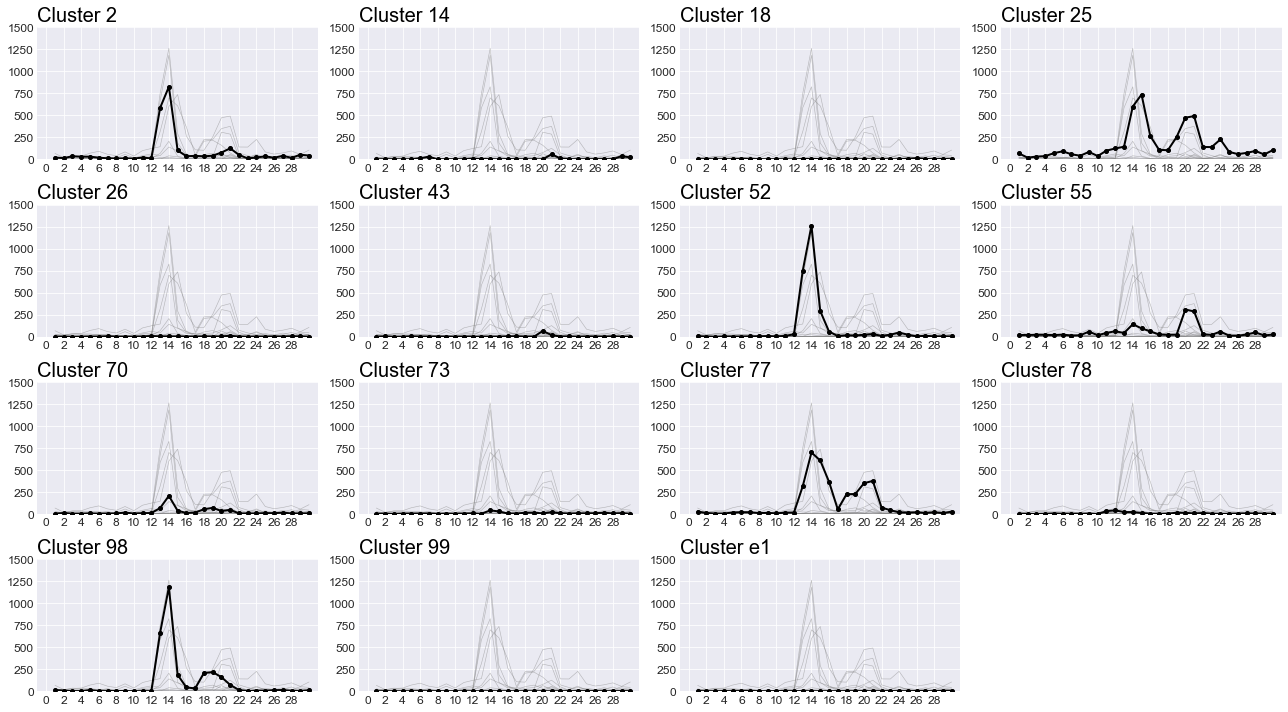

In [63]:
plot_topic_freq(mx_topic_freq, ylim=1500)

In [64]:
plot_topic_freq(co_topic_freq, ylim=800)

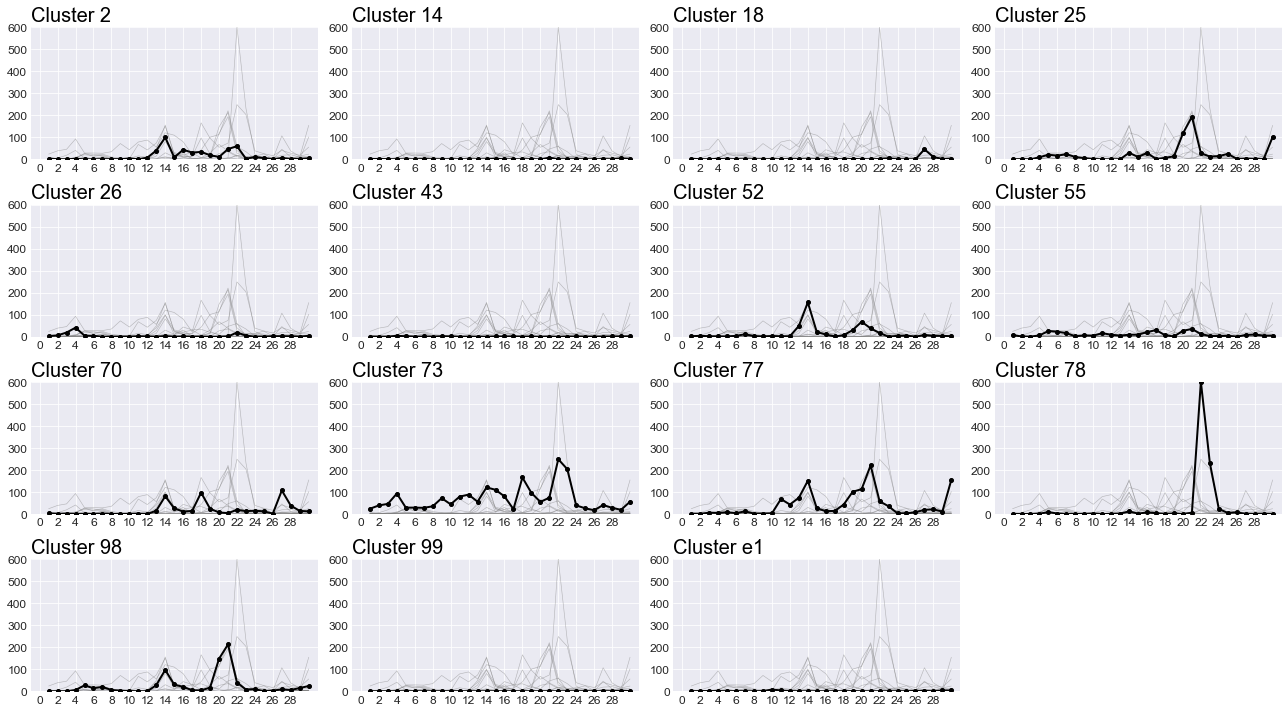

In [65]:
plot_topic_freq(ve_topic_freq, ylim=600)

In [90]:
def plot_topic_freq_country(country_topic_freq, cluster_id, country_name, ylim):
    '''
    inspired by https://python-graph-gallery.com/125-small-multiples-for-line-chart/
    '''
    # Initialize the figure
    plt.style.use('seaborn-darkgrid')

    # create a color palette
    palette = plt.get_cmap('Dark2')
    
    f, ax = plt.subplots()

    plt.plot(country_topic_freq.index, country_topic_freq[cluster_id].values, 
             marker='o', markersize=4, color='black', 
             linewidth=2, alpha=1)

    plt.xlim(-1,31)
    plt.ylim(0,ylim)

    # xticks only show odd numbers (otherwise too crowded)
    odd_nums = [x for x in range(30) if x%2==0]
    plt.xticks(odd_nums,size='large')
    plt.yticks(size='large')

    # Add title
    plt.title("Country: "+ country_name.upper(), loc='left', fontsize=20, fontweight=0, color='black')

    f.tight_layout() 
    
    f.savefig(figure_path + "ts_" + country_name + "_" + cluster_id)

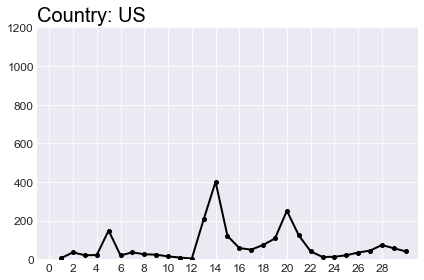

In [96]:
plot_topic_freq_country(us_topic_freq, '98', 'us', 1200)

In [97]:
plot_topic_freq_country(mx_topic_freq, '98', 'mx', 1200)

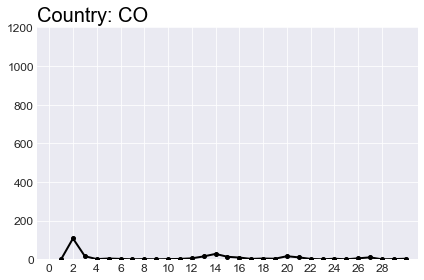

In [99]:
plot_topic_freq_country(co_topic_freq, '98', 'co', 1200)

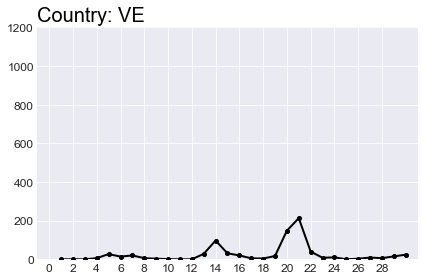

In [98]:
plot_topic_freq_country(ve_topic_freq, '98', 've', 1200)

In [181]:
def get_countries_corr(topic_freq1, topic_freq2, topics_of_interest):
    corr_pd = pd.DataFrame(index=topics_of_interest, columns=['corr', 'p_value'])
    for cluster_id in topics_of_interest:
        corr, p_value = stats.pearsonr(topic_freq1[cluster_id], topic_freq2[cluster_id])
        corr_pd.loc[cluster_id, :] = [corr, p_value]
    return corr_pd
# get_countries_corr(co_topic_freq, ve_topic_freq, us_topic_freq.columns)

In [263]:
def compare_peak_dates(topic_freq_list):
    '''
    the peaks are pretty obvious by observation, this is just to quantify them
    compare time series peaks with prominence higher than certain threshold
    the threshold helps to filter out small peaks that are noises because we care about the general trends
    '''
    peak_dfs = [find_peaks(topic_freq, prominence=200) for topic_freq in topic_freq_list]
    for topic_id in peak_dfs[0].columns:
        print(topic_id)
        for peak_df in peak_dfs:
            peak_prominences = peak_df[topic_id]
            peak_dates = peak_prominences.to_numpy().nonzero()
            print("...", list(peak_dates[0]))
        print("\n")
# compare_peak_dates([us_topic_freq, mx_topic_freq])

## 2.2 Spatial mapping of cluster frequencies
- step 2: heatmap of peak day for a topic (e.g., a topic that is very different in different countries)
- folium: https://alcidanalytics.com/p/geographic-heatmap-in-python

In [120]:
def mapping(locations):
    hmap = folium.Map(location=[22.367413, -93.639503], width=1000, height=700)
    HeatMap(locations, tiles = "OpenStreetMap", radius=12).add_to(hmap)
    hmap.fit_bounds([[-5.039006, -122.830282], [49.183317, -52.490825]]) 
    return hmap

def save_png(hmap, filename):
    path = "/Users/xiaoyi/gitbucket/dissertation/cartel_project/paper/figures/"
    hmap.save(path + filename + '.html')
    browser = webdriver.Chrome('/Users/xiaoyi/.wdm/drivers/chromedriver/81.0.4044.138/mac64/chromedriver')
    browser.get('file://' + path + filename + '.html')
    time.sleep(5)  #Give the map tiles some time to load
    browser.save_screenshot(path + filename + '.png')
    browser.quit()

In [110]:
def map_cluster(cluster_id, day, filename):
    cluster = relevant_data[relevant_data['cluster_label']==cluster_id]
    cluster_day = cluster[cluster['day']==day]
    locations = cluster_day['coordinates'].apply(lambda row: [row.split(',')[1],row.split(',')[0]])
    hmap = mapping(locations)
    save_png(hmap, figure_path+filename)
    return hmap

In [125]:
hmap = map_cluster('98', '14')
save_png(hmap, "cluster98_day14")

In [126]:
hmap = map_cluster('98', '18')
save_png(hmap, 'cluster98_day18')

In [127]:
hmap = map_cluster('98', '19')
save_png(hmap,'cluster98_day19')

In [128]:
hmap = map_cluster('98', '20')
save_png(hmap, 'cluster98_day20')

In [129]:
hmap = map_cluster('98', '21')
save_png(hmap, 'cluster98_day21')

In [225]:
# why does ve has higher cluster 98 on day 21
ve_21 = topic98_day21[topic98_day21['country']=='ve']

In [229]:
ve_14 = topic98_day14[topic98_day14['country']=='ve']